This one came up during a conversation with Felix Pultar, a postdoc in the group, and I thought it made for a nice blog post, so here we go.

One common workflow in conformational analysis is to generate a bunch of conformers for a molecule and then find a representative subset by clustering them.

The RDKit has everything required to do this, but there's not all that much info out there showing how to do it. 

This blog post aims to change that.

In [1]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolAlign
import rdkit
print(rdkit.__version__)

2022.09.4


# Generate conformers

Start by constructing a molecule and then generating a set of 300 conformers for it using [ETKDGv3](https://doi.org/10.1021/acs.jcim.0c00025).

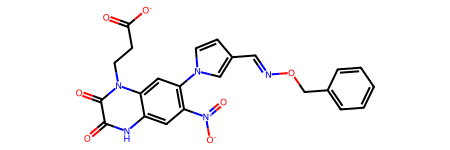

In [2]:
# modified CHEMBL12747, ionized
m = Chem.MolFromSmiles('O=C([O-])CCn1c(=O)c(=O)[nH]c2cc([N+](=O)[O-])c(-n3ccc(C=NOCc4ccccc4)c3)cc21')
m

In [3]:
mh = Chem.AddHs(m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xd06f00d
ps.numThreads = 10
cids = rdDistGeom.EmbedMultipleConfs(mh,300,ps)
len(cids)

300

Remove Hs from the molecule at this point because they aren't 
particularly informative for the rest of the analysis and they
just make things more difficult


In [4]:
m3d = Chem.RemoveHs(mh)

# Direct alignment vs best alignment

Find a pair of conformers with a decent size mismatch between the direct alignment (which does not take symmetry into account) and the best alignment (which does):

In [5]:
maxd = -100
for j in range(0,5):
    for i in range(j,len(cids)):
        d1 = rdMolAlign.AlignMol(m3d,m3d,prbCid=cids[i],refCid=cids[j])
        d2 = rdMolAlign.GetBestRMS(m3d,m3d,prbId=cids[i],refId=cids[j])
        delt = d1-d2
        if delt<-1e-5:
            print(f'ooops, {i}, {delt}')
        if delt>maxd:
            maxd = delt
            maxi = i
            maxj = j
d1 = rdMolAlign.AlignMol(m3d,m3d,prbCid=cids[maxi],refCid=cids[maxj])
d2 = rdMolAlign.GetBestRMS(m3d,m3d,prbId=cids[maxi],refId=cids[maxj])
print(maxi,maxd,d1,d2)

282 0.703433090406554 1.0038182177331938 0.3003851273604343


Now show those two conformers:

In [6]:
import py3Dmol
def drawit(m, cids=[-1], p=None, removeHs=True,
           colors=('cyanCarbon','redCarbon','blueCarbon','magentaCarbon','whiteCarbon','purpleCarbon')):
        if removeHs:
            m = Chem.RemoveHs(m)
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,cid in enumerate(cids):
            IPythonConsole.addMolToView(m,p,confId=cid)
        for i,cid in enumerate(cids):
            p.setStyle({'model':i,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

Here are the two conformers aligned using the atom indices:

In [7]:
d1 = rdMolAlign.AlignMol(m3d,m3d,prbCid=cids[maxi],refCid=cids[maxj])
drawit(m3d,[cids[maxj],cids[maxi]])


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And then aligned with GetBestRMS:

In [8]:
d2 = rdMolAlign.GetBestRMS(m3d,m3d,prbId=cids[maxi],refId=cids[maxj])
drawit(m3d,[cids[maxj],cids[maxi]])


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The alignments don't actually look all that different. The difference in RMSD is due to the atoms in the nitro group and the terminal phenyl ring: `GetBestRMS()` recognizes that the symmetry while `AlignMol()` just matches atoms by their indices.

# Cluster

Now generate the RMSD distance matrix using `GetBestRMS()`. Note that as of the 2022.09 release cycle the convenience function `AllChem.GetConformerRMSMatrix()` does not take symmetry into account, so we need to build the symmetric matrix (we just store the lower triangle) manually:

In [9]:
dists = []
for i in range(len(cids)):
    for j in range(i):
        dists.append(rdMolAlign.GetBestRMS(m3d,m3d,i,j))

Now we can do Butina clustering. We use a distance threshold of 1.5 &Aring;:

In [10]:
from rdkit.ML.Cluster import Butina
clusts = Butina.ClusterData(dists, len(cids), 1.5, isDistData=True, reordering=True)
len(clusts)

10

That's it. The 300 conformers form 10 clusters. Let's visualize the centroids (the first conformer in each cluster)


To make visualization of the clusters easier to interpret, align all the conformers to the rigid 6-6 core:

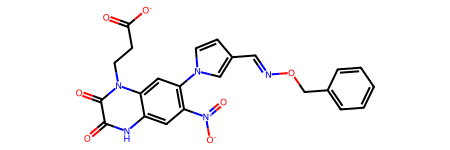

In [11]:
m

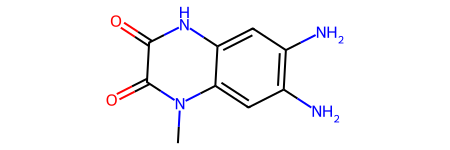

In [12]:
core = Chem.MolFromSmiles('O=C1C(=O)N(C)c2cc(N)c(N)cc2N1')
core

In [13]:
rdMolAlign.AlignMolConformers(m3d,atomIds = m3d.GetSubstructMatch(core))

Now look at the first five cluster centroids;

In [14]:
centroids = [x[0] for x in clusts]
drawit(m3d,centroids[:5])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

It's also possible to cluster molecules using [torsion fingerprint differences (TFDs)](https://doi.org/10.1021/ci2002318), but that's a topic for another post.
